<a href="https://colab.research.google.com/github/Tclack88/MountainProject/blob/master/HangboardProgress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import datetime as dt
from numpy import log
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# df = pd.read_excel('MorganHB1.xlsx')
# df = pd.read_excel('TrevorHB.xlsx')
# doc = 'https://github.com/Tclack88/MountainProject/blob/master/MorganHB.xlsx?raw=true'
# doc = 'https://github.com/Tclack88/MountainProject/blob/master/TrevorHB.xlsx?raw=true'
# doc = 'https://github.com/Tclack88/MountainProject/blob/master/TrevorHB_maxhangs.xlsx?raw=true'
doc = 'https://github.com/Tclack88/MountainProject/blob/master/TrevorHB_kg.xlsx?raw=true'

In [13]:
df = pd.read_excel(doc)
name = doc.split('/')[-1].split('.')[0][:-5] # cheap way of getting climber name under assumption it's saved as "nameHB_kg" or "nameHB_lb"
weight_type = doc.split('/')[-1].split('.')[0][-2:] # returns kg or lb. Same assumption as above
df.date = pd.to_datetime(df.date)
df.date = pd.to_datetime(df.date, format = '%d %b %Y')
df = df.set_index('date')
cols = df.columns

In [41]:
df

,jug,imr,med_edge,pinch_med,mr_2fp,large_edge,pinch_wide,sloper,mrp_3fp
date,,,,,,,,,
2022-06-26,"0,6","-6,2,7,5,6,5","-6,4,7,6","-14,6","-20,5,6","-10,4,8,7","-14,5,8","-18,2,5,6,5,4","-16,2,7,6,6,4"
2022-06-29,"0,6","-8,5,8","-10,2,6,6,6,6","-14,6","-19.5,6","-10,5,8","-14,4,7,7","-19,4,7,7","-16.5,4,5,7"
2022-07-06,"0,6","-8,6","-10,5,7","-14,6","-19,6","-9,5,8","-14,6","-19,5,9","-16,4,7,7"
2022-07-11,"0,6","-7,6","-9,3,7,7,6","-20,0","-18.5,6","-8,6","-12,6","-18.5,6","-16,6"
2022-07-16,"0,6","-6.5,6","-9,4,7,6","-16,6","-18,6","-7,6","-16,6","-18,6","-15,6"
2022-07-19,"0,6","-6,6","-9,6","-15.5,6","-17.5,6","-6.5,6","-14,6","-17.5,5,9","-14.5,6"
2022-07-28,"0,6","-5.5,6","-8.5,3,8,8,7","-15,6","-16.5,6","-6,6","-13.5,5,7","-17.5,4,7,8","-14,5,6"
2022-08-06,"0,6","-5,6","-8.5,2,9,9,7,5","-14.5,6","-15,6","-5.5,6","-13.5,6","-17.5,6","-13.5,5,7"
2022-08-09,"0,6","-4.5,6","-8.5,5,9","-14,6","-14.5,6","-5,6","-13,4,8,6","-17,5,9","-13,3,7,7,6"


In [43]:
regular_cols = [col for col in df.columns if ':' not in ''.join(df[col])] # may need .join(df[col].astype(str)). Check later
one_hand_df = df.loc[df.apply(lambda x: ':' in x.to_string(), axis=1), df.columns.difference(regular_cols)] # get only the values containing ":"
two_hand_df = df.applymap(lambda x: np.nan if ':' in str(x) else x) # replace all "cells" containing ":" with a NaN
two_hand_df

,jug,imr,med_edge,pinch_med,mr_2fp,large_edge,pinch_wide,sloper,mrp_3fp
date,,,,,,,,,
2022-06-26,"0,6","-6,2,7,5,6,5","-6,4,7,6","-14,6","-20,5,6","-10,4,8,7","-14,5,8","-18,2,5,6,5,4","-16,2,7,6,6,4"
2022-06-29,"0,6","-8,5,8","-10,2,6,6,6,6","-14,6","-19.5,6","-10,5,8","-14,4,7,7","-19,4,7,7","-16.5,4,5,7"
2022-07-06,"0,6","-8,6","-10,5,7","-14,6","-19,6","-9,5,8","-14,6","-19,5,9","-16,4,7,7"
2022-07-11,"0,6","-7,6","-9,3,7,7,6","-20,0","-18.5,6","-8,6","-12,6","-18.5,6","-16,6"
2022-07-16,"0,6","-6.5,6","-9,4,7,6","-16,6","-18,6","-7,6","-16,6","-18,6","-15,6"
2022-07-19,"0,6","-6,6","-9,6","-15.5,6","-17.5,6","-6.5,6","-14,6","-17.5,5,9","-14.5,6"
2022-07-28,"0,6","-5.5,6","-8.5,3,8,8,7","-15,6","-16.5,6","-6,6","-13.5,5,7","-17.5,4,7,8","-14,5,6"
2022-08-06,"0,6","-5,6","-8.5,2,9,9,7,5","-14.5,6","-15,6","-5.5,6","-13.5,6","-17.5,6","-13.5,5,7"
2022-08-09,"0,6","-4.5,6","-8.5,5,9","-14,6","-14.5,6","-5,6","-13,4,8,6","-17,5,9","-13,3,7,7,6"


In [50]:
# Create a new DataFrame to hold the split values
split_df = pd.DataFrame()

# Loop over each column in one_hand_df and split on the colon
for col in one_hand_df.columns:
    # Create new columns for each side of the colon
    split_cols = [col + '_R', col + '_L']
    
    # Apply a lambda function to split on the colon and fillna with empty strings
    split_data = one_hand_df[col].apply(lambda x: pd.Series(x.split(':'))).fillna('')
    
    # Rename the columns to include _R and _L
    split_data.columns = split_cols
    
    # Add the split data to the split_df DataFrame
    split_df[split_cols] = split_data

# Combine the split_df and one_hand_df DataFrames
one_handsplit_df = pd.concat([one_hand_df.index.to_frame(), split_df], axis=1)
one_handsplit_df = one_handsplit_df.drop(columns = ['date'])

In [59]:
one_handsplit_df.pinch_med_R

date
2022-11-09      R,14,6
2022-11-16      R,14,6
2022-11-24      R,14,6
2022-11-27      R,14,6
2022-12-14    R,14.5,6
2022-12-24      R,15,6
Name: pinch_med_R, dtype: object

In [61]:
one_handsplit_df.apply(lambda x: ','.join(x.to_string().split(',')[1:]))  ### LEFT OFF HERE (POPPING OFF THE L AND R TO EACH CELL

pinch_med_R     14,6\n2022-11-16      R,14,6\n2022-11-24      ...
pinch_med_L     14,2,6,4,4,4\n2022-11-16      L,14,4,6,6,8\n20...
pinch_wide_R    12,6\n2022-11-16        R,12,6\n2022-11-24    ...
pinch_wide_L    2,6,4,4,4\n2022-11-16      L,12,3,6,6,6\n2022-...
dtype: object

In [17]:
df.loc[df[cols].apply(lambda x: any(':' in s for s in x), axis=1), cols]

,jug,imr,med_edge,pinch_med,mr_2fp,large_edge,pinch_wide,sloper,mrp_3fp
date,,,,,,,,,
2022-11-09,"0,6","-5,5,9","-9,3,7,6,5","R,14,6:L,14,2,6,4,4,4","-16,5,7","-6,5,7","R,12,6:L,2,6,4,4,4","-17,4,8,8","-14.5,4,6,6"
2022-11-16,"0,6","-4.5,5,8","-8.5,3,6,6,7","R,14,6:L,14,4,6,6,8","-16,6","-6,5,9","R,12,6:L,12,3,6,6,6","-17,4,8,8","-14.5,4,6,6"
2022-11-24,"0,6","-4.5,6","-8.5,3,8,9,7","R,14,6:L,14,3,7,6,5","-15,6","-5.5,6","R,12,6:L,12,4,7,4","-17,6","-14.5,6"
2022-11-27,"0,6","-4,5,7","-8.5,3,8,9,7","R,14,6:L,14,6","-14.5,6","-5,6","R,12.5,6:L,12.5,3,5,4,5","-16.5,5,7","-14,6"
2022-12-14,"0,6","-4,6","-8.5,5,9","R,14.5,6:L,14.5,5,7","-14,6","-4.5,6","R,12.5,5,7:L,12.5,4,5,5","-16,3,8,7,7","-13.5,4,8,2"
2022-12-24,"0,6","-3.5,5,8","-8,4,8,5","R,15,6:L,15,2.5,7,5,5","-13.5,5,8","-4,5,8","R,12.5,5,7:L,12.5,3,6,5,4","-16,5,8","-13.5,5,5"


In [ ]:
def process_hangboard_for_plot(doc, HANGTIME, N_ROUNDS):
  # Initial processing of excel doc
  df = pd.read_excel(doc)
  name = doc.split('/')[-1].split('.')[0][:-5] # cheap way of getting climber name under assumption it's saved as "nameHB_kg" or "nameHB_lb"
  weight_type = doc.split('/')[-1].split('.')[0][-2:] # returns kg or lb. Same assumption as above
  today = dt.datetime.today().strftime('%d %b %Y')
  df.date = pd.to_datetime(df.date)
  df.date = pd.to_datetime(df.date, format = '%d %b %Y')
  df = df.set_index('date')
  print(df)
  # Create new df ready for plot
  cols = df.columns
  hangs = []
  for col in cols:
    column = df[col]
    inner_df = column.str.split(',', expand=True).fillna(0) # looks like an error happens if I don't first do this, pardon the redundancy
    if len(inner_df.columns) == 2:
      inner_df[2] = 0
      inner_df[3] = HANGTIME*N_ROUNDS
      inner_df[4] = 0
    else:
      inner_df[1] = inner_df[1].apply(pd.to_numeric) # change to numeric columns
      # print(inner_df.dtypes)
      inner_df.insert(2, 'fail', N_ROUNDS - inner_df[1])
      inner_df.insert(3, 'TUT', HANGTIME*inner_df[1] + (inner_df.iloc[:,3:]).apply(pd.to_numeric).sum(axis=1))
      inner_df.insert(4, 'penalty_factor', log(N_ROUNDS + 1 - inner_df[1])/log(6)) #apply log base 6 as penalty factor (log(6,6) = 1.0 for failing all but one, log(6,1) = 0 for failing none
      inner_df = inner_df.iloc[:,:5]
    inner_df.columns = ['weight','success','fail','TUT','penalty_factor',]
    inner_df = inner_df[['weight','success','fail','TUT','penalty_factor']]
    inner_df = inner_df.apply(pd.to_numeric) # change to numeric columns
    inner_df.TUT = inner_df.TUT/(HANGTIME*N_ROUNDS) # change TUT (Time under tension to a fraction of ex. 60 seconds later for coloring)
    hang = inner_df[['weight','TUT','penalty_factor']]
    hang.index.name = 'Date'
    hang = hang.reset_index()
    hang['effective_weight'] = hang.weight - 2.5 * (hang.penalty_factor) - 2.5 * (1 - hang.TUT) # arbitrary penalty of 2.5 lbs for low TUT and penalty for low total successful reps
    hangs.append(hang)
  return hangs, cols, name, today

# change here 6 for repeaters, 2 for max hangs
hangs, cols, name, today = process_hangboard_for_plot(doc, 10, 6)

            jug        imr  ...         sloper          mrp_3fp
date                        ...                                
2019-10-26  0,6      -20,6  ...          -35,6            -45,6
2019-10-29  0,6  -17.5,5,5  ...        -32.5,6          -42.5,6
2019-11-01  0,6    -27.5,6  ...      -30,4,9,7          -40,5,6
2019-11-04  0,6    -27.5,6  ...          -30,6            -40,6
2019-11-07  0,6      -25,6  ...      -27.5,5,8      -37.5,5,9.5
2019-11-10  0,6    -22.5,6  ...      -25,4,5,8          -35,5,7
2019-11-13  0,6      -20,6  ...  -22.5,3,8,7,6      -32.5,4,8,7
2020-02-08  0,6      -30,6  ...  -32.5,3,9,6,8        -42.5,5,6
2020-02-11  0,6      -30,6  ...        -32.5,6          -42.5,6
2020-02-14  0,6    -27.5,6  ...        -30,5,7            -40,6
2020-02-18  0,6      -25,6  ...    -30,3,7,7,7    -37.5,3,9,5,8
2020-02-21  0,6      -25,6  ...          -30,6          -37.5,6
2020-02-24  0,6    -22.5,6  ...    -27.5,4,8,7          -35,5,7
2020-02-27  0,6      -20,6  ...      -27

In [ ]:
fig = go.Figure()

ending_weights = []

for hang in hangs:
  ending_weight = hang.effective_weight.to_list()[-1]
  ending_weights.append(ending_weight)
  fig.add_trace(go.Scatter(x=hang.index, y=hang.effective_weight, mode='lines+markers'))

# Adding labels
annotations = []
for ending_weight, col in zip(ending_weights, cols):
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=1, y=ending_weight,
                                  xanchor='left', yanchor='middle',
                                  text=f'{col}',
                                  font=dict(family='Arial',
                                            size=16),
                                  showarrow=False))
    
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Hangboard Progress',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1,
                              xanchor='left', yanchor='bottom',
                              text=f'{name} - as of {today}',
                              font=dict(family='Arial',
                                        size=20,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

fig.update_layout(annotations=annotations,
                  width = 1000,
                  height=800,
                  showlegend=False, # alternatively can show legend (default to True) and remove label on right
                  xaxis = dict(
                      tickmode = 'array',
                      tickvals = hang.index,
                      ticktext = hang.Date,
                      tickformat = '%d%b%Y',
                      ),
                  yaxis = dict(
                      tickmode = 'array',
                      title = 'weight (lbs from body weight)'
                      ))
fig.show()

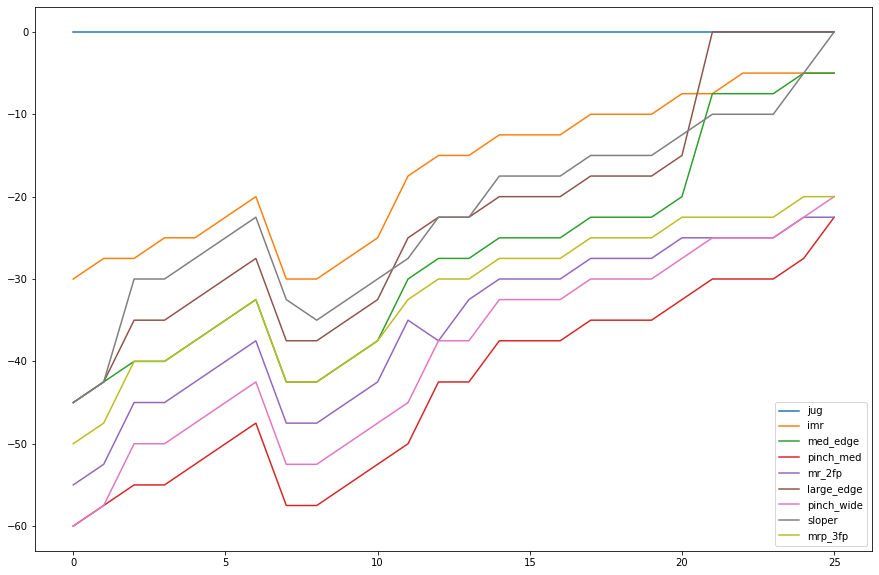

In [ ]:
# With Seaborn
plt.figure(figsize=(15,10))
for hang in hangs:
  plt.plot(hang.index, hang.weight)

plt.legend(cols)
plt.show();